# Machine Learning with PyTorch

## Tasks with Networks

<font size="+1">A simple feature classifier</font>
<a href="NetworkExamples_0.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1"><u><b>An image classifier</b></u></font>
<a href="NetworkExamples_1.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">A regression prediction</font>
<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Clustering with PyTorch</font>
<a href="NetworkExamples_3.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Generative Adversarial Networks (GAN)</font> 
<a href="NetworkExamples_4.ipynb"><img src="img/open-notebook.png" align="right"/></a>

<font size="+1">Part of Speech Tagger</font>
<a href="NetworkExamples_5.ipynb"><img src="img/open-notebook.png" align="right"/></a>

In [1]:
%matplotlib inline
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.nn import Sequential, Conv2d, MaxPool2d, Linear, Module
import torch.optim as optim

# For demonstration, we can use CPU target if CUDA not available
device = torch.device('cpu')

# Check the status of the GPU (if present)
if torch.cuda.is_available():
    print("CUDA memory used:", torch.cuda.memory_allocated())
    device = torch.device('cuda') 

CUDA memory used: 0


## An image classifier

To get a feel for an image classifier, let us setup one very close to that presented in the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).  We will change a few details and add some commentary, but most of the code follows that.  

One notable change is that by adjusting learning rate in the training loop, we achieve considerably better results than in the tutorial while using an identical network.

The output of torchvision datasets are PILImage images of range `[0, 1]`. We transform them to Tensors of normalized range `[-1, 1]`.  I.e.:

```
# For one color plane
pixel = (pixel - mean) / std
# (0-0.5) / 0.5 == -1
# (1-0.5) / 0.5 == 1
```

In [2]:
batch_size = 16
transform = Compose([
    Resize(32),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


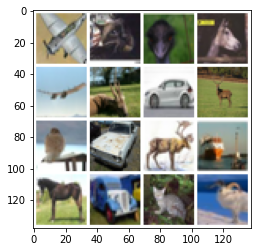

Labels: plane cat bird horse plane deer car deer bird car deer ship horse truck cat deer


In [3]:
# Function to show an image
def imshow(images):
    grid = make_grid(images, padding=2, pad_value=2, nrow=4)
    grid = grid/2 + 0.5     # denormalize [-1, 1] -> [0, 1]
    npimg = grid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images and labels
imshow(images)
print('Labels:', ' '.join(classes[labels[j]] for j in range(batch_size)))

The PyTorch tutorial uses a more object-oriented style than shown.  I prefer the more declarative (and more concise) style of `torch.nn.Sequential`.  The OOP style requires a separate `.__init__()` method to configure layers, then a `.forward()` to actually utilize them.  To me, this feels excessively imperative and bug-prone.

```python
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
```

Unfortunately, the developers of PyTorch currently endorse the OOP style, and to that end of removed `torch.nn.View` as a separate declarative layer, making reshaping in layers more difficult.  We can work around that by creating our own `Flatten` layer.

In [4]:
class Flatten(Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
   
    def forward(self, x):
        return x.view(-1, self.shape) 
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.shape})"

In [5]:
model = Sequential(
    Conv2d(3, 6, 5),
    MaxPool2d(2, 2),
    Conv2d(6, 16, 5),
    MaxPool2d(2, 2),
    Flatten(400),
    Linear(400, 120),
    Linear(120, 84),
    Linear(84, 10)
).to(device)
model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(400)
  (5): Linear(in_features=400, out_features=120, bias=True)
  (6): Linear(in_features=120, out_features=84, bias=True)
  (7): Linear(in_features=84, out_features=10, bias=True)
)

Trainable parameters:

In [6]:
grad_params = filter(lambda p: p.requires_grad, model.parameters())
print("Trainable parameters:",
      f"{sum([np.prod(p.size()) for p in grad_params]):,.0f}")

Trainable parameters: 62,006


In [7]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

The time it takes for training to terminate and the final loss and model accuracy are very sensitive to the schedule of decaying the learning rate.  The below is a good compromise for this particular dataset, but I played around with numerous variations.  The best of these will reach a running loss of 0.89 and an accuracy of 63%.  Of course, I have not explored the entire near-infinite space of possible schedules.

In [8]:
%%time
# Expect ~9 min
early_stop = 4
running_loss = []  # Every loss computation
loss_history = []  # Intermittent averages

# Loop over the dataset multiple times
for epoch in range(1, 100):  
    for batch, data in enumerate(trainloader, 0):
        # get the inputs, put them on GPU if available
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics periodically
        if batch % 1000 == 999:
            rloss = mean(running_loss[-1000:])
            loss_history.append(rloss)
            print(f'Epoch {epoch}; '
                  f' Batch {batch+1:4d} '
                  f'- Running-Loss: {rloss} '
                  f'(lr={optimizer.param_groups[0]["lr"]:0.8f})')
             
            
    ## Lower learning rate by 2x if no improvement in loss for multiple epochs
    diff = max(loss_history[-early_stop:]) - min(loss_history[-early_stop:])
    if  diff/loss_history[-1] < 0.02:
        optimizer.param_groups[0]['lr'] /= 2 

    ## If learning rate is lowered to tiny value, we are not getting anywhere
    if optimizer.param_groups[0]['lr'] < 1e-8:           
        print("+++ Discontinuing training regime when loss becomes constant")
        break

Epoch 1;  Batch 1000 - Running-Loss: 2.0627666923999786 (lr=0.00100000)
Epoch 1;  Batch 2000 - Running-Loss: 1.7517819612026215 (lr=0.00100000)
Epoch 1;  Batch 3000 - Running-Loss: 1.6119316418766976 (lr=0.00100000)
Epoch 2;  Batch 1000 - Running-Loss: 1.5276785236597061 (lr=0.00100000)
Epoch 2;  Batch 2000 - Running-Loss: 1.490994288802147 (lr=0.00100000)
Epoch 2;  Batch 3000 - Running-Loss: 1.4328465929031373 (lr=0.00100000)
Epoch 3;  Batch 1000 - Running-Loss: 1.3889636110663415 (lr=0.00100000)
Epoch 3;  Batch 2000 - Running-Loss: 1.361915956377983 (lr=0.00100000)
Epoch 3;  Batch 3000 - Running-Loss: 1.3401283141970635 (lr=0.00100000)
Epoch 4;  Batch 1000 - Running-Loss: 1.2993983861207963 (lr=0.00100000)
Epoch 4;  Batch 2000 - Running-Loss: 1.28103849619627 (lr=0.00100000)
Epoch 4;  Batch 3000 - Running-Loss: 1.2760984662771224 (lr=0.00100000)
Epoch 5;  Batch 1000 - Running-Loss: 1.2517647467255593 (lr=0.00100000)
Epoch 5;  Batch 2000 - Running-Loss: 1.2349866952300073 (lr=0.001000

In [9]:
dataiter = iter(testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


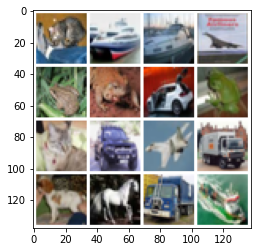

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Truth,cat,ship,ship,plane,frog,frog,car,frog,cat,car,plane,truck,dog,horse,truck,ship
Predict,cat,car,ship,plane,frog,frog,car,frog,cat,car,plane,truck,dog,horse,truck,ship


In [10]:
images, labels = dataiter.next()
outputs = model(images.to(device))
_, predict = torch.max(outputs.data, 1)

# Print images
imshow(images)

# Show the ground truth
import pandas as pd
df = pd.DataFrame({'Truth': labels.cpu(), 'Predict': predict.cpu()})
df['Truth'] = df.Truth.map(lambda i: classes[i])
df['Predict'] = df.Predict.map(lambda i: classes[i])
df.T

## Success?

I think this relatively simple model with 62k weights does reasonably well.  The CIFAR10 image dataset has ten (balanced) classes as its targets, so random selection would get an accuracy of 10%.  Of course, the leading edge images classifiers—with hundreds of layers and millions of trainable weights (in some cases [**billions**](https://arxiv.org/abs/1811.06965)!)—do quite a bit better than our sample network.  But this is not bad.

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


## Next Lesson

**Tasks with Networks**: We constructed a fairly good image classifier with just a bit of code.  Clearly, this classifier is less powerful than competition-winning leading ones with hundreds of layers; but just a few layers makes reasonably good predictions.  Next we will reframe the domain area classification problem we looked at in the last lesson as a regression problem.

<a href="NetworkExamples_2.ipynb"><img src="img/open-notebook.png" align="left"/></a>